In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=0.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x, min_val=0.0, max_val=1.0)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_s

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,save_best=True, save_thr=90)

100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [1/100], Step [657/657], Loss: 2.4691, Accuracy: 0.1147
Accuracy of the network: 0.178 Loss: 2.0385960970364563


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [2/100], Step [657/657], Loss: 2.0083, Accuracy: 0.1909
Accuracy of the network: 0.19177777777777777 Loss: 2.0139002013713756


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [3/100], Step [657/657], Loss: 1.9826, Accuracy: 0.1940
Accuracy of the network: 0.1831111111111111 Loss: 2.0279092661877898


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [4/100], Step [657/657], Loss: 1.9746, Accuracy: 0.1991
Accuracy of the network: 0.2021111111111111 Loss: 1.9319720707886607


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [5/100], Step [657/657], Loss: 1.9538, Accuracy: 0.2020
Accuracy of the network: 0.20622222222222222 Loss: 1.9408050800891632


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [6/100], Step [657/657], Loss: 1.9397, Accuracy: 0.2123
Accuracy of the network: 0.191 Loss: 1.9802931082164141


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [7/100], Step [657/657], Loss: 1.9334, Accuracy: 0.2079
Accuracy of the network: 0.1438888888888889 Loss: 2.1137889133277517


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [8/100], Step [657/657], Loss: 1.9183, Accuracy: 0.2159
Accuracy of the network: 0.21455555555555555 Loss: 1.9050117088547835


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [9/100], Step [657/657], Loss: 1.6405, Accuracy: 0.3297
Accuracy of the network: 0.47 Loss: 1.3690397684455764


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [10/100], Step [657/657], Loss: 1.0951, Accuracy: 0.5880
Accuracy of the network: 0.6941111111111111 Loss: 0.8544360595814725


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [11/100], Step [657/657], Loss: 0.7959, Accuracy: 0.7121
Accuracy of the network: 0.7695555555555555 Loss: 0.6475492518210242


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [12/100], Step [657/657], Loss: 0.6606, Accuracy: 0.7686
Accuracy of the network: 0.7418888888888889 Loss: 0.7181380145938684


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [13/100], Step [657/657], Loss: 0.5810, Accuracy: 0.8016
Accuracy of the network: 0.8547777777777777 Loss: 0.46147456321310487


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [14/100], Step [657/657], Loss: 0.5097, Accuracy: 0.8265
Accuracy of the network: 0.8802222222222222 Loss: 0.37942842312209996


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [15/100], Step [657/657], Loss: 0.4742, Accuracy: 0.8412
Accuracy of the network: 0.9005555555555556 Loss: 0.3410339022042058


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [16/100], Step [657/657], Loss: 0.4218, Accuracy: 0.8643
Accuracy of the network: 0.9025555555555556 Loss: 0.32036392993115365


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [17/100], Step [657/657], Loss: 0.3912, Accuracy: 0.8706
Accuracy of the network: 0.9032222222222223 Loss: 0.3120974801375088


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [18/100], Step [657/657], Loss: 0.3576, Accuracy: 0.8844
Accuracy of the network: 0.8913333333333333 Loss: 0.3344123585955471


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [19/100], Step [657/657], Loss: 0.3305, Accuracy: 0.8935
Accuracy of the network: 0.8292222222222222 Loss: 0.5118548376551757


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [20/100], Step [657/657], Loss: 0.3136, Accuracy: 0.9005
Accuracy of the network: 0.9128888888888889 Loss: 0.2817796789215389


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [21/100], Step [657/657], Loss: 0.3002, Accuracy: 0.9045
Accuracy of the network: 0.938 Loss: 0.2211675357786899


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [22/100], Step [657/657], Loss: 0.2874, Accuracy: 0.9095
Accuracy of the network: 0.9446666666666667 Loss: 0.19935020379035184


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [23/100], Step [657/657], Loss: 0.2687, Accuracy: 0.9170
Accuracy of the network: 0.9457777777777778 Loss: 0.19081858194149132


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [24/100], Step [657/657], Loss: 0.2498, Accuracy: 0.9224
Accuracy of the network: 0.9405555555555556 Loss: 0.20607445212015024


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [25/100], Step [657/657], Loss: 0.2405, Accuracy: 0.9276
Accuracy of the network: 0.9362222222222222 Loss: 0.21367588751546457


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [26/100], Step [657/657], Loss: 0.2324, Accuracy: 0.9297
Accuracy of the network: 0.9467777777777778 Loss: 0.187508923457341


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [27/100], Step [657/657], Loss: 0.2253, Accuracy: 0.9311
Accuracy of the network: 0.9522222222222222 Loss: 0.16881124018063992


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [28/100], Step [657/657], Loss: 0.2104, Accuracy: 0.9364
Accuracy of the network: 0.9557777777777777 Loss: 0.15956202696295493


100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [29/100], Step [657/657], Loss: 0.2060, Accuracy: 0.9386
Accuracy of the network: 0.9522222222222222 Loss: 0.17077360884781848


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [30/100], Step [657/657], Loss: 0.1982, Accuracy: 0.9415
Accuracy of the network: 0.9488888888888889 Loss: 0.17687992772734756


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [31/100], Step [657/657], Loss: 0.1865, Accuracy: 0.9458
Accuracy of the network: 0.9561111111111111 Loss: 0.1665080624718404


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [32/100], Step [657/657], Loss: 0.1881, Accuracy: 0.9458
Accuracy of the network: 0.9536666666666667 Loss: 0.15805194744879894


100%|██████████| 657/657 [03:34<00:00,  3.07it/s]


Epoch [33/100], Step [657/657], Loss: 0.1776, Accuracy: 0.9463
Accuracy of the network: 0.9615555555555556 Loss: 0.14025680167296678


100%|██████████| 657/657 [03:32<00:00,  3.10it/s]


Epoch [34/100], Step [657/657], Loss: 0.1707, Accuracy: 0.9507
Accuracy of the network: 0.9623333333333334 Loss: 0.14204286973500715


100%|██████████| 657/657 [03:10<00:00,  3.45it/s]


Epoch [35/100], Step [657/657], Loss: 0.1643, Accuracy: 0.9525
Accuracy of the network: 0.9586666666666667 Loss: 0.14762732942740545


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [36/100], Step [657/657], Loss: 0.1642, Accuracy: 0.9519
Accuracy of the network: 0.9618888888888889 Loss: 0.14040718995140378


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [37/100], Step [657/657], Loss: 0.1593, Accuracy: 0.9538
Accuracy of the network: 0.9657777777777777 Loss: 0.1281117581108466


100%|██████████| 657/657 [02:27<00:00,  4.45it/s]


Epoch [38/100], Step [657/657], Loss: 0.1540, Accuracy: 0.9570
Accuracy of the network: 0.964 Loss: 0.13013539508196478


100%|██████████| 657/657 [02:46<00:00,  3.94it/s]


Epoch [39/100], Step [657/657], Loss: 0.1523, Accuracy: 0.9544
Accuracy of the network: 0.9634444444444444 Loss: 0.13311569125173575


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [40/100], Step [657/657], Loss: 0.1471, Accuracy: 0.9569
Accuracy of the network: 0.9652222222222222 Loss: 0.12894220170003515


100%|██████████| 657/657 [03:25<00:00,  3.19it/s]


Epoch [41/100], Step [657/657], Loss: 0.1452, Accuracy: 0.9592
Accuracy of the network: 0.9632222222222222 Loss: 0.13344221050910493


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [42/100], Step [657/657], Loss: 0.1346, Accuracy: 0.9624
Accuracy of the network: 0.9671111111111111 Loss: 0.12302177972721716


100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [43/100], Step [657/657], Loss: 0.1361, Accuracy: 0.9616
Accuracy of the network: 0.9678888888888889 Loss: 0.120853524539514


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [44/100], Step [657/657], Loss: 0.1395, Accuracy: 0.9600
Accuracy of the network: 0.9632222222222222 Loss: 0.12827611738379965


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [45/100], Step [657/657], Loss: 0.1322, Accuracy: 0.9622
Accuracy of the network: 0.967 Loss: 0.11771620127062003


100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [46/100], Step [657/657], Loss: 0.1305, Accuracy: 0.9630
Accuracy of the network: 0.9681111111111111 Loss: 0.118061596970239


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [47/100], Step [657/657], Loss: 0.1304, Accuracy: 0.9638
Accuracy of the network: 0.9695555555555555 Loss: 0.11451993809999726


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [48/100], Step [657/657], Loss: 0.1296, Accuracy: 0.9641
Accuracy of the network: 0.967 Loss: 0.11600504032210678


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [49/100], Step [657/657], Loss: 0.1324, Accuracy: 0.9622
Accuracy of the network: 0.9673333333333334 Loss: 0.11973794539135399


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [50/100], Step [657/657], Loss: 0.1256, Accuracy: 0.9647
Accuracy of the network: 0.9683333333333334 Loss: 0.11405673137278105


100%|██████████| 657/657 [03:49<00:00,  2.86it/s]


Epoch [51/100], Step [657/657], Loss: 0.1229, Accuracy: 0.9671
Accuracy of the network: 0.971 Loss: 0.11136718815628519


100%|██████████| 657/657 [04:02<00:00,  2.71it/s]


Epoch [52/100], Step [657/657], Loss: 0.1224, Accuracy: 0.9664
Accuracy of the network: 0.9706666666666667 Loss: 0.11307405296660272


100%|██████████| 657/657 [03:53<00:00,  2.81it/s]


Epoch [53/100], Step [657/657], Loss: 0.1228, Accuracy: 0.9663
Accuracy of the network: 0.9711111111111111 Loss: 0.10785265395034713


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [54/100], Step [657/657], Loss: 0.1200, Accuracy: 0.9670
Accuracy of the network: 0.9708888888888889 Loss: 0.10784485234040106


100%|██████████| 657/657 [03:21<00:00,  3.26it/s]


Epoch [55/100], Step [657/657], Loss: 0.1200, Accuracy: 0.9663
Accuracy of the network: 0.9714444444444444 Loss: 0.10764041350797769


100%|██████████| 657/657 [03:22<00:00,  3.25it/s]


Epoch [56/100], Step [657/657], Loss: 0.1191, Accuracy: 0.9664
Accuracy of the network: 0.9693333333333334 Loss: 0.11127826145433999


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [57/100], Step [657/657], Loss: 0.1185, Accuracy: 0.9676
Accuracy of the network: 0.9714444444444444 Loss: 0.10690014796490048


100%|██████████| 657/657 [03:27<00:00,  3.16it/s]


Epoch [58/100], Step [657/657], Loss: 0.1171, Accuracy: 0.9676
Accuracy of the network: 0.9693333333333334 Loss: 0.11038385961759598


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [59/100], Step [657/657], Loss: 0.1168, Accuracy: 0.9690
Accuracy of the network: 0.9712222222222222 Loss: 0.10719084962938272


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [60/100], Step [657/657], Loss: 0.1147, Accuracy: 0.9680
Accuracy of the network: 0.9715555555555555 Loss: 0.1040348699448485


100%|██████████| 657/657 [03:34<00:00,  3.07it/s]


Epoch [61/100], Step [657/657], Loss: 0.1146, Accuracy: 0.9687
Accuracy of the network: 0.9718888888888889 Loss: 0.105152580662505


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [62/100], Step [657/657], Loss: 0.1108, Accuracy: 0.9696
Accuracy of the network: 0.9705555555555555 Loss: 0.10832128533763243


100%|██████████| 657/657 [03:20<00:00,  3.28it/s]


Epoch [63/100], Step [657/657], Loss: 0.1098, Accuracy: 0.9706
Accuracy of the network: 0.9726666666666667 Loss: 0.10369262651454472


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [64/100], Step [657/657], Loss: 0.1130, Accuracy: 0.9682
Accuracy of the network: 0.9737777777777777 Loss: 0.10415287264655773


100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [65/100], Step [657/657], Loss: 0.1119, Accuracy: 0.9692
Accuracy of the network: 0.9732222222222222 Loss: 0.10361862493058045


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [66/100], Step [657/657], Loss: 0.1131, Accuracy: 0.9697
Accuracy of the network: 0.9708888888888889 Loss: 0.10267061878867606


100%|██████████| 657/657 [03:31<00:00,  3.10it/s]


Epoch [67/100], Step [657/657], Loss: 0.1124, Accuracy: 0.9684
Accuracy of the network: 0.9734444444444444 Loss: 0.10275277371538129


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [68/100], Step [657/657], Loss: 0.1108, Accuracy: 0.9701
Accuracy of the network: 0.9726666666666667 Loss: 0.10343003383315835


100%|██████████| 657/657 [02:24<00:00,  4.54it/s]


Epoch [69/100], Step [657/657], Loss: 0.1118, Accuracy: 0.9697
Accuracy of the network: 0.9716666666666667 Loss: 0.10459432094390933


100%|██████████| 657/657 [02:26<00:00,  4.49it/s]


Epoch [70/100], Step [657/657], Loss: 0.1087, Accuracy: 0.9703
Accuracy of the network: 0.9724444444444444 Loss: 0.10347631624536523


100%|██████████| 657/657 [02:24<00:00,  4.53it/s]


Epoch [71/100], Step [657/657], Loss: 0.1122, Accuracy: 0.9702
Accuracy of the network: 0.972 Loss: 0.1043677243489957


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [72/100], Step [657/657], Loss: 0.1126, Accuracy: 0.9678
Accuracy of the network: 0.972 Loss: 0.10678962928553422


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [73/100], Step [657/657], Loss: 0.1138, Accuracy: 0.9679
Accuracy of the network: 0.9726666666666667 Loss: 0.10277658817853699


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [74/100], Step [657/657], Loss: 0.1132, Accuracy: 0.9692
Accuracy of the network: 0.9727777777777777 Loss: 0.1040545572321994


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [75/100], Step [657/657], Loss: 0.1100, Accuracy: 0.9699
Accuracy of the network: 0.9716666666666667 Loss: 0.10312825850217688


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [76/100], Step [657/657], Loss: 0.1121, Accuracy: 0.9694
Accuracy of the network: 0.9723333333333334 Loss: 0.10352004104762846


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [77/100], Step [657/657], Loss: 0.1115, Accuracy: 0.9704
Accuracy of the network: 0.9731111111111111 Loss: 0.10205895046485548


100%|██████████| 657/657 [02:27<00:00,  4.45it/s]


Epoch [78/100], Step [657/657], Loss: 0.1080, Accuracy: 0.9701
Accuracy of the network: 0.9704444444444444 Loss: 0.10624641548604408


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [79/100], Step [657/657], Loss: 0.1111, Accuracy: 0.9702
Accuracy of the network: 0.9714444444444444 Loss: 0.10345432120012053


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [80/100], Step [657/657], Loss: 0.1109, Accuracy: 0.9703
Accuracy of the network: 0.971 Loss: 0.10480321253524393


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [81/100], Step [657/657], Loss: 0.1111, Accuracy: 0.9676
Accuracy of the network: 0.9734444444444444 Loss: 0.10105550414321164


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [82/100], Step [657/657], Loss: 0.1112, Accuracy: 0.9688
Accuracy of the network: 0.9725555555555555 Loss: 0.10424528823478531


100%|██████████| 657/657 [02:29<00:00,  4.40it/s]


Epoch [83/100], Step [657/657], Loss: 0.1073, Accuracy: 0.9719
Accuracy of the network: 0.9735555555555555 Loss: 0.10300260213210333


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [84/100], Step [657/657], Loss: 0.1103, Accuracy: 0.9700
Accuracy of the network: 0.9731111111111111 Loss: 0.10402536071202856


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [85/100], Step [657/657], Loss: 0.1125, Accuracy: 0.9692
Accuracy of the network: 0.9726666666666667 Loss: 0.10267436370940496


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [86/100], Step [657/657], Loss: 0.1083, Accuracy: 0.9703
Accuracy of the network: 0.9718888888888889 Loss: 0.10351997461328481


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [87/100], Step [657/657], Loss: 0.1107, Accuracy: 0.9703
Accuracy of the network: 0.9723333333333334 Loss: 0.10162633497611429


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [88/100], Step [657/657], Loss: 0.1097, Accuracy: 0.9700
Accuracy of the network: 0.9722222222222222 Loss: 0.10348422832602093


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [89/100], Step [657/657], Loss: 0.1087, Accuracy: 0.9698
Accuracy of the network: 0.9703333333333334 Loss: 0.10549579062730285


100%|██████████| 657/657 [02:26<00:00,  4.49it/s]


Epoch [90/100], Step [657/657], Loss: 0.1054, Accuracy: 0.9706
Accuracy of the network: 0.9732222222222222 Loss: 0.10118939421727513


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [91/100], Step [657/657], Loss: 0.1077, Accuracy: 0.9714
Accuracy of the network: 0.9718888888888889 Loss: 0.10391508177556891


100%|██████████| 657/657 [02:29<00:00,  4.40it/s]


Epoch [92/100], Step [657/657], Loss: 0.1093, Accuracy: 0.9697
Accuracy of the network: 0.9733333333333334 Loss: 0.09997118424941251


100%|██████████| 657/657 [02:25<00:00,  4.51it/s]


Epoch [93/100], Step [657/657], Loss: 0.1078, Accuracy: 0.9712
Accuracy of the network: 0.9721111111111111 Loss: 0.10257250128036484


100%|██████████| 657/657 [02:26<00:00,  4.50it/s]


Epoch [94/100], Step [657/657], Loss: 0.1105, Accuracy: 0.9701
Accuracy of the network: 0.9715555555555555 Loss: 0.10293332689791812


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [95/100], Step [657/657], Loss: 0.1087, Accuracy: 0.9701
Accuracy of the network: 0.9717777777777777 Loss: 0.10442165439248297


100%|██████████| 657/657 [02:25<00:00,  4.51it/s]


Epoch [96/100], Step [657/657], Loss: 0.1100, Accuracy: 0.9700
Accuracy of the network: 0.9725555555555555 Loss: 0.1018184863215854


100%|██████████| 657/657 [02:57<00:00,  3.69it/s]


Epoch [97/100], Step [657/657], Loss: 0.1107, Accuracy: 0.9702
Accuracy of the network: 0.9717777777777777 Loss: 0.10226762743917762


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [98/100], Step [657/657], Loss: 0.1077, Accuracy: 0.9708
Accuracy of the network: 0.9732222222222222 Loss: 0.10192698655081979


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [99/100], Step [657/657], Loss: 0.1113, Accuracy: 0.9688
Accuracy of the network: 0.974 Loss: 0.10072080667150464


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [100/100], Step [657/657], Loss: 0.1101, Accuracy: 0.9699
Accuracy of the network: 0.9722222222222222 Loss: 0.10373240431229062


In [10]:
torch.save(model, "best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.pt")


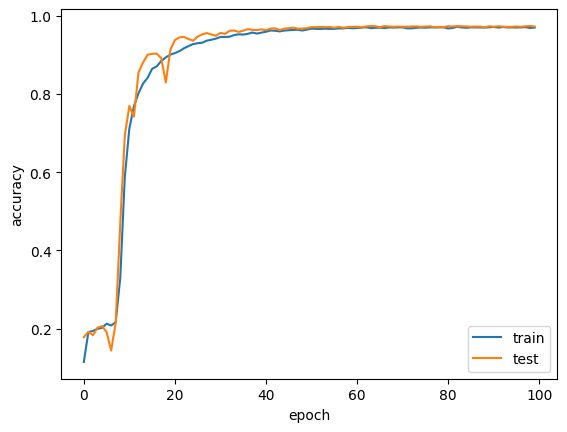

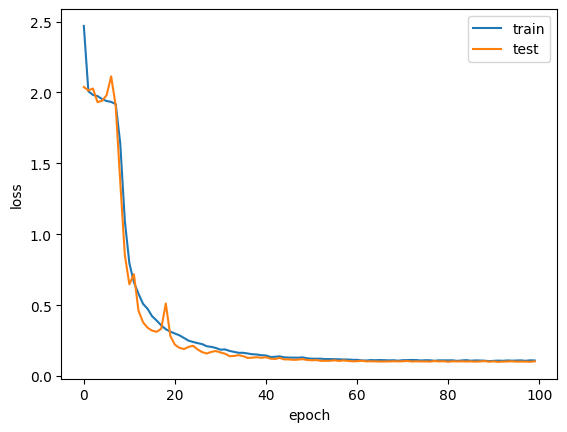

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.114667,0.178000,2.469147,2.038596
1,0.190905,0.191778,2.008294,2.013900
2,0.194000,0.183111,1.982605,2.027909
3,0.199143,0.202111,1.974620,1.931972
4,0.201952,0.206222,1.953841,1.940805
